# Results Summary

In [1]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
annotated_features = ['expanse', 'object', 
                 'agent distance', 'facingness', 'joint action', 
                 'communication', 'valence', 'arousal']
rois = ['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS']

## Vision Models

### Behavior

In [3]:
files = glob(f'../data/interim/VisionBehaviorEncoding/*.csv.gz')
files.sort(key=os.path.getmtime)
df = []
for file in files:
    df.append(pd.read_csv(file))
df = pd.concat(df)

In [4]:
def get_max_score(group, col='train_score'):
    return group.loc[group[col].idxmax()]

In [5]:
max_scores = df.groupby(['feature', 'model_uid']).apply(get_max_score).reset_index(drop=True)
rename_mapping = {orig: orig.replace('rating-', '').replace('_', ' ') for orig in max_scores.feature.unique()}
max_scores = pd.melt(max_scores, id_vars=["model_uid", "model_layer", "model_layer_index", "feature"], 
                    value_vars=["train_score", "test_score"], 
                    var_name="set", value_name="score")
max_scores['feature'] = max_scores['feature'].replace(rename_mapping)
max_scores['feature'] = pd.Categorical(max_scores['feature'], categories=annotated_features, ordered=True)
max_scores['set'] = max_scores['set'].replace({'train_score': 'train', 'test_score': 'test'})
max_scores['set'] = pd.Categorical(max_scores['set'], categories=['train', 'test'], ordered=True)

/tmp/ipykernel_3425343/3200536758.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=40, ha='right')


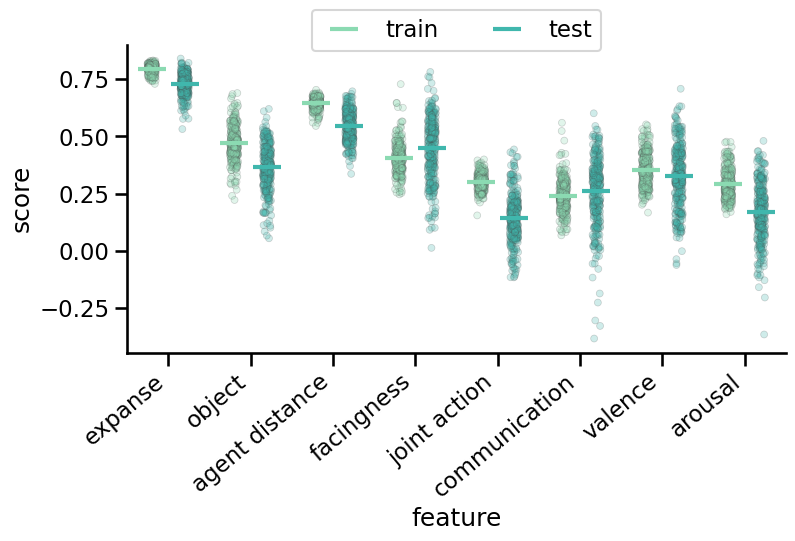

In [6]:
sns.set_context('talk', rc = {'patch.edgecolor': 'black', 'patch.force_edgecolor': True})
_, ax = plt.subplots(figsize=(8.5,4))
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
# sns.barplot(x='feature', y='score', hue='metric', data=max_scores,
#             ax=ax, dodge=True, errorbar=None, palette=color,legend=False, zorder=0)
sns.stripplot(x='feature', y='score', hue='set', data=max_scores,
              ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
sns.pointplot(x='feature', y='score', hue='set', data=max_scores,
               dodge=.4, linestyle="none", errorbar=None,
              marker="_", markersize=20, markeredgewidth=3, zorder=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, rotation=40, ha='right')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True)

### Neural data

In [42]:
files = glob(f'../data/interim/VisionNeuralEncoding/*.csv.gz')
print(f'{len(file)} neural encoding models found')
df = []
for file in files:
    df.append(pd.read_csv(file))
df = pd.concat(df)

69 neural encoding models found


In [8]:
def get_max_score(group, col='train_score'):
    return group.loc[group[col].idxmax()]

In [9]:
max_scores = df.groupby(['roi_name', 'model_uid']).apply(get_max_score).reset_index(drop=True)
max_scores = max_scores.loc[max_scores.roi_name.isin(rois)].reset_index(drop=True)
max_scores = pd.melt(max_scores, id_vars=["model_uid", "layer", "layer_index", "layer_relative_depth", "roi_name"], 
                    value_vars=["train_score", "test_score"], 
                    var_name="set", value_name="score")
# max_scores['feature'] = max_scores['feature'].replace(rename_mapping)
max_scores['roi_name'] = pd.Categorical(max_scores['roi_name'], categories=rois, ordered=True)
max_scores['set'] = max_scores['set'].replace({'train_score': 'train', 'test_score': 'test'})
max_scores['set'] = pd.Categorical(max_scores['set'], categories=['train', 'test'], ordered=True)

/tmp/ipykernel_3425343/113316931.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')


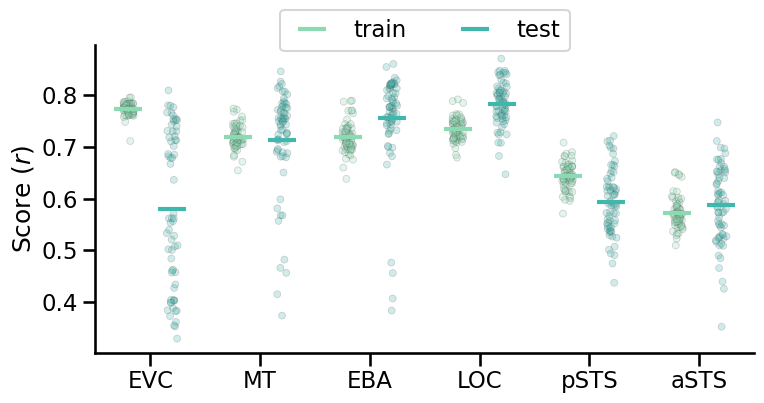

In [39]:
sns.set_context('talk', rc = {'patch.edgecolor': 'black', 'patch.force_edgecolor': True})
_, ax = plt.subplots(figsize=(8.5,4))
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
# sns.barplot(x='feature', y='score', hue='metric', data=max_scores,
#             ax=ax, dodge=True, errorbar=None, palette=color,legend=False, zorder=0)
sns.stripplot(x='roi_name', y='score', hue='set', data=max_scores,
              ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
sns.pointplot(x='roi_name', y='score', hue='set', data=max_scores,
               dodge=.4, linestyle="none", errorbar=None,
              marker="_", markersize=20, markeredgewidth=3, zorder=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, ha='center')
ax.set_xlabel('')
ax.set_ylabel('Score ($r$)')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True)

/tmp/ipykernel_3425343/3378780553.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max_scores_test_avg = max_scores_test.groupby('roi_name').mean(numeric_only=True)
/tmp/ipykernel_3425343/3378780553.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')


(0.0, 1.0)

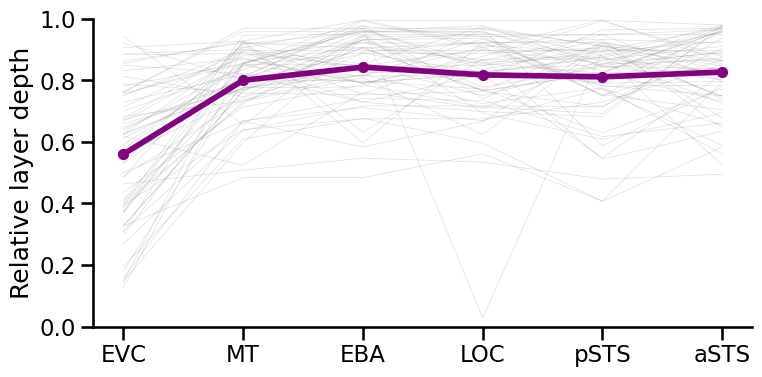

In [40]:
sns.set_context('talk', rc = {'patch.edgecolor': 'black', 'patch.force_edgecolor': True})
_, ax = plt.subplots(figsize=(8.5,4))
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
unique_model_uids = max_scores['model_uid'].unique()
color_palette = {uid: 'gray' for uid in unique_model_uids}

max_scores_test = max_scores[max_scores.set == 'test'].reset_index(drop=True)
max_scores_test_avg = max_scores_test.groupby('roi_name').mean(numeric_only=True)

sns.pointplot(x='roi_name', y='layer_relative_depth', data=max_scores_test_avg,
             marker='.', markersize=10, zorder=1, color='purple')
sns.lineplot(x='roi_name', y='layer_relative_depth', hue='model_uid', data=max_scores_test,
              ax=ax, linewidth=.5, alpha=0.25, zorder=0, legend=False, palette=color_palette)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, ha='center')
ax.set_xlabel('')
ax.set_ylabel('Relative layer depth')
ax.set_ylim([0,1])
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
#           ncol=3, fancybox=True)